In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/ProjF/' 

Mounted at /content/gdrive


In [ ]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from numpy import array
import tensorflow as tf
from pickle import load
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input

In [ ]:
#Execute this cell only if you dont have the features.pkl (For now, dont implement this)
# extract features from each photo in the directory
def extract_features(directory):
		# load the model
		model = Xception()
		# re-structure the model
		model.layers.pop()
		model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
		# summarize
		print(model.summary())
		# extract features from each photo
		features = dict()
		for name in listdir(directory):
				# load an image from file
				filename = directory + '/' + name
				# image = load_img(filename, target_size=(224, 224)) #for vgg16,vgg19,resnet50
				image = load_img(filename, target_size=(299, 299)) #for inceptionv3,xception
				# convert the image pixels to a numpy array
				image = img_to_array(image)
				# reshape data for the model
				image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
				# prepare the image for the VGG model
				image = preprocess_input(image)
				# get features
				feature = model.predict(image, verbose=0)
				# get image id
				image_id = name.split('.')[0]
				# store feature
				features[image_id] = feature
				print('>%s' % name)
		return features

# extract features from all images
directory = root_path+'flickr8k/images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open(root_path+'xception_features.pkl', 'wb'))

91897856/91884032 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

KeyboardInterrupt: ignored

In [ ]:
#Helper Functions
import string

# load doc into memory
def load_doc(filename):
		# open the file as read only
		file = open(filename, 'r')
		# read all text
		text = file.read()
		# close the file
		file.close()
		return text


# load a pre-defined list of photo identifiers
def load_set(filename):
		doc = load_doc(filename)
		dataset = list()
		# process line by line
		for line in doc.split('\n'):
				# skip empty lines
				if len(line) < 1:
					continue
				# get the image identifier
				identifier = line.split('.')[0]
				dataset.append(identifier)
		return set(dataset)

# extract descriptions for images
def load_descriptions(doc):
		mapping = dict()
		# process lines
		for line in doc.split('\n'):
				# split line by white space
				tokens = line.split()
				if len(line) < 2:
						continue
				# take the first token as the image id, the rest as the description
				image_id, image_desc = tokens[0], tokens[1:]
				# remove filename from image id
				image_id = image_id.split('.')[0]
				# convert description tokens back to string
				image_desc = ' '.join(image_desc)
				# create the list if needed
				if image_id not in mapping:
						mapping[image_id] = list()
				# store description
				mapping[image_id].append(image_desc)
		return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
		table = str.maketrans('', '', string.punctuation)
		for key, desc_list in descriptions.items():
				for i in range(len(desc_list)):
						desc = desc_list[i]
						# tokenize
						desc = desc.split()
						# convert to lower case
						desc = [word.lower() for word in desc]
						# remove punctuation from each token
						desc = [w.translate(table) for w in desc]
						# remove hanging 's' and 'a'
						desc = [word for word in desc if len(word)>1]
						# remove tokens with numbers in them
						desc = [word for word in desc if word.isalpha()]
						# store as string
						desc_list[i] =  ' '.join(desc)
			
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
		# build a list of all description strings
		all_desc = set()
		for key in descriptions.keys():
				[all_desc.update(d.split()) for d in descriptions[key]]
		return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
		lines = list()
		for key, desc_list in descriptions.items():
				for desc in desc_list:
						lines.append(key + ' ' + desc)
		data = '\n'.join(lines)
		file = open(filename, 'w')
		file.write(data)
		file.close()


In [ ]:
# filename = 'Flickr8k_text/Flickr8k.token.txt'
filename = root_path+'flickr8k/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, root_path+'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
			tokens = line.split()
		# split id from description
			image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
			if image_id in dataset:
				# create list
					if image_id not in descriptions:
						descriptions[image_id] = list()
					# wrap description in tokens
					desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
					# store
					descriptions[image_id].append(desc)
	return descriptions


	 
# load photo features
def load_photo_features(filename, dataset):
		# load all features
		all_features = load(open(filename, 'rb'))
		# filter features
		features = {k: all_features[k] for k in dataset}
		return features


In [ ]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [ ]:
# prepare training set

# load training dataset (6K)
filename = root_path+'flickr8k/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(root_path+'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features(root_path+'xception_features.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(root_path+'tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
train_max_length = max_length(train_descriptions)
print('Description Length: %d' % train_max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [ ]:
# prepare Validation set

# load Validation set
filename = root_path+'flickr8k/Flickr_8k.devImages.txt'
val = load_set(filename)
print('Dataset: %d' % len(val))
# descriptions
val_descriptions = load_clean_descriptions(root_path+'descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))
# photo features
val_features = load_photo_features(root_path+'xception_features.pkl', val)
print('Photos: val=%d' % len(val_features))


Dataset: 1000
Descriptions: val=1000
Photos: val=1000


In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    # inputs1 = Input(shape=(4096,))     #for vgg16,vgg19
    inputs1 = Input(shape=(2048,))     #for resnet50,inception,xception
    fe1 = Dropout(0.5)(inputs1)
    # fe1 = Dropout(0.875)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [ ]:
#Below code is used to progressively load the batch of data
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]

In [ ]:
# train the model
model = define_model(vocab_size, train_max_length)

earlyStopping = EarlyStopping(monitor='val_loss', patience=12, verbose=0, mode='min')
mcp_save = ModelCheckpoint(root_path+'Models/xception_model_best_dropout_5.h5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, epsilon=1e-4, mode='min')

n_epochs = 10
steps = len(train_descriptions)
size_of_batch = 16
train_generator = data_generator(train_descriptions, train_features, tokenizer, train_max_length)
val_generator = data_generator(val_descriptions, val_features, tokenizer, train_max_length)
history_model = model.fit(train_generator, epochs=n_epochs,batch_size=size_of_batch, steps_per_epoch=6000//size_of_batch,verbose=1,
                          callbacks=[earlyStopping,mcp_save,reduce_lr_loss], validation_data=val_generator,validation_steps=1000//size_of_batch,use_multiprocessing = False)

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 34, 256)      1940224     ['input_41[0][0]']               
                                                                                                  
 dropout_12 (Dropout)           (None, 2048)         0           ['input_40[0][0]']               
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


375/375 [==============================] - 48s 115ms/step - loss: 5.9683 - val_loss: 5.5342 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - ETA: 0s - loss: 5.3388
Epoch 00002: val_loss improved from 5.53417 to 4.94390, saving model to gdrive/MyDrive/ProjF/Models/xception_model_best_dropout_5.h5
375/375 [==============================] - 42s 112ms/step - loss: 5.3388 - val_loss: 4.9439 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 4.8817
Epoch 00003: val_loss improved from 4.94390 to 4.70138, saving model to gdrive/MyDrive/ProjF/Models/xception_model_best_dropout_5.h5
375/375 [==============================] - 42s 112ms/step - loss: 4.8817 - val_loss: 4.7014 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - ETA: 0s - loss: 4.7447
Epoch 00004: val_loss improved from 4.70138 to 4.64787, saving model to gdrive/MyDrive/ProjF/Models/xception_model_best_dropout_5.h5
375/375 [==============================] - 42s 111ms/st

In [ ]:
dump(history_model.history, open(root_path+'xception_history_dropout_5.pkl', 'wb'))

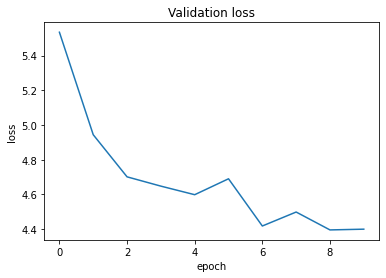

In [ ]:
model_plot = load(open(root_path+'xception_history_dropout_5.pkl', 'rb'))
plt.plot(model_plot['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Tuning the hyperparameters
# define the captioning model
def define_model(vocab_size, max_length,dropout_value):
    # feature extractor model
    # inputs1 = Input(shape=(4096,))     #for vgg16,vgg19
    inputs1 = Input(shape=(2048,))     #for resnet50,inception,xception
    fe1 = Dropout(dropout_value)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [ ]:
# train the model
dropout_list = [0.125,0.25,0.5,0.75,1]
for i in range(len(dropout_list)):
    model = define_model(vocab_size, train_max_length,dropout_list[i])
    earlyStopping = EarlyStopping(monitor='val_loss', patience=12, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(root_path+'Models/xception_model_best_dropout_' + str(i) + '.h5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, epsilon=1e-4, mode='min')

    n_epochs = 50
    steps = len(train_descriptions)
    size_of_batch = 16
    train_generator = data_generator(train_descriptions, train_features, tokenizer, train_max_length)
    val_generator = data_generator(val_descriptions, val_features, tokenizer, train_max_length)
    history_model = model.fit(train_generator, epochs=n_epochs,batch_size=size_of_batch, steps_per_epoch=6000//size_of_batch,verbose=1,
                              callbacks=[earlyStopping,mcp_save,reduce_lr_loss], validation_data=val_generator,validation_steps=1000//size_of_batch,use_multiprocessing = False)
    dump(history_model.history, open(root_path+'xception_history_dropout_' + str(i) + '.pkl', 'wb'))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


375/375 [==============================] - 49s 116ms/step - loss: 5.9517 - val_loss: 5.3632 - lr: 0.0010
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 5.2781
Epoch 00002: val_loss improved from 5.36323 to 4.92100, saving model to gdrive/MyDrive/ProjF/Models/xception_model_best_dropout_0.h5
375/375 [==============================] - 42s 112ms/step - loss: 5.2781 - val_loss: 4.9210 - lr: 0.0010
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 4.8342
Epoch 00003: val_loss improved from 4.92100 to 4.64019, saving model to gdrive/MyDrive/ProjF/Models/xception_model_best_dropout_0.h5
375/375 [==============================] - 42s 112ms/step - loss: 4.8342 - val_loss: 4.6402 - lr: 0.0010
Epoch 4/50
375/375 [==============================] - ETA: 0s - loss: 4.6820
Epoch 00004: val_loss improved from 4.64019 to 4.58666, saving model to gdrive/MyDrive/ProjF/Models/xception_model_best_dropout_0.h5
375/375 [==============================] - 42s 112ms/st

ValueError: ignored

In [ ]:
history_model_xception = [load(open(root_path+'xception_history_dropout_0.pkl', 'rb')),load(open(root_path+'xception_history_dropout_1.pkl', 'rb')),
                          load(open(root_path+'xception_history_dropout_2.pkl', 'rb')),load(open(root_path+'xception_history_dropout_3.pkl', 'rb')),
                          load(open(root_path+'xception_history_dropout_4.pkl', 'rb'))]


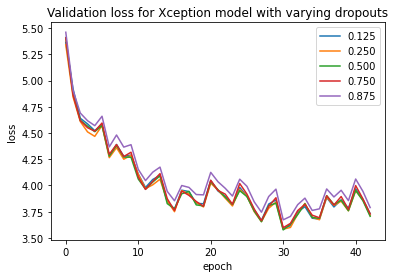

In [ ]:
#For Dropout hyperparameter optimization
# summarize history for accuracy
# summarize history for loss
from matplotlib.pyplot import figure

# figure(figsize=(15, 15))
plt.plot(history_model_xception[0]['val_loss'])
plt.plot(history_model_xception[1]['val_loss'])
plt.plot(history_model_xception[2]['val_loss'])
plt.plot(history_model_xception[3]['val_loss'])
plt.plot(history_model_xception[4]['val_loss'])

plt.title('Validation loss for Xception model with varying dropouts')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['0.125','0.250','0.500','0.750','0.875'], loc='upper right')
plt.show()

In [ ]:
dump(history_model.history, open(root_path+'xception_history.pkl', 'wb'))

In [ ]:
history_model_vgg16 = load(open(root_path+'vgg16_history.pkl', 'rb'))
history_model_vgg19 = load(open(root_path+'vgg19_history.pkl', 'rb'))
history_model_resnet50 = load(open(root_path+'resnet50_history.pkl', 'rb'))
history_model_inceptionV3 = load(open(root_path+'inceptionV3_history.pkl', 'rb'))
history_model_xception = load(open(root_path+'xception_history.pkl', 'rb'))

In [ ]:
print(history_model)

{'loss': [5.803165912628174, 5.231807231903076, 4.805788516998291, 4.670541763305664, 4.509615421295166, 4.540281772613525, 4.478033542633057, 4.6272101402282715, 4.503326892852783, 4.407008171081543, 4.30620813369751, 4.371482849121094, 4.328171253204346, 4.311801433563232, 4.0966339111328125, 4.191703796386719, 4.047978401184082, 4.076054573059082, 3.879084825515747, 3.859910249710083, 3.7905678749084473, 3.8552005290985107, 3.8306403160095215, 3.996321678161621, 3.9223198890686035, 3.898810863494873, 3.906597375869751, 3.99355149269104, 3.986147165298462, 3.982060670852661, 3.7891650199890137, 3.912247896194458, 3.8234150409698486, 3.9003958702087402, 3.7498576641082764, 3.776181221008301, 3.70088529586792, 3.7669320106506348, 3.7706069946289062, 3.93412709236145, 3.87031626701355, 3.8693220615386963, 3.8651933670043945], 'val_loss': [5.325117111206055, 4.877678394317627, 4.649382591247559, 4.569192409515381, 4.548031806945801, 4.636499404907227, 4.376718997955322, 4.468791484832764

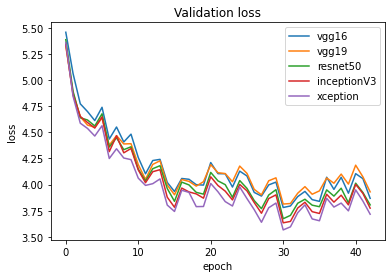

In [ ]:
# summarize history for accuracy
# summarize history for loss
from matplotlib.pyplot import figure

# figure(figsize=(15, 15))
plt.plot(history_model_vgg16['val_loss'])
plt.plot(history_model_vgg19['val_loss'])
plt.plot(history_model_resnet50['val_loss'])
plt.plot(history_model_inceptionV3['val_loss'])
plt.plot(history_model_xception['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['vgg16','vgg19','resnet50','inceptionV3','xception'], loc='upper right')
plt.show()

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
		for word, index in tokenizer.word_index.items():
				if index == integer:
						return word
		return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
		# seed the generation process
		in_text = 'startseq'
		# iterate over the whole length of the sequence
		for i in range(max_length):
				# integer encode input sequence
				sequence = tokenizer.texts_to_sequences([in_text])[0]
				# pad input
				sequence = pad_sequences([sequence], maxlen=max_length)
				# predict next word
				yhat = model.predict([photo,sequence], verbose=0)
				# convert probability to integer
				yhat = argmax(yhat)
				# map integer to word
				word = word_for_id(yhat, tokenizer)
				# stop if we cannot map the word
				if word is None:
						break
				# append as input for generating the next word
				in_text += ' ' + word
				# stop if we predict the end of the sequence
				if word == 'endseq':
						break
		return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
		actual, predicted = list(), list()
		# step over the whole set
		for key, desc_list in descriptions.items():
				# generate description:
				yhat = generate_desc(model, tokenizer, photos[key], max_length)
				# store actual and predicted
				references = [d.split() for d in desc_list]
				actual.append(references)
				predicted.append(yhat.split())
			# calculate BLEU score
		print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
		print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
		print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
		print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# prepare training set

# load training dataset (6K)
filename = root_path+'flickr8k/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(root_path+'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
# train_features = load_photo_features(root_path+'features.pkl', train)
train_features = load_photo_features(root_path+'xception_features.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(root_path+'tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
train_max_length = max_length(train_descriptions)
print('Description Length: %d' % train_max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [ ]:
# prepare test set

# load test set
filename = root_path+'flickr8k/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions(root_path+'descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
# test_features = load_photo_features(root_path+'features.pkl', test)
test_features = load_photo_features(root_path+'xception_features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
# load the model which has minimum loss, in this case it was xception_model_best_dropout_2.h5
filename = root_path+'Models/xception_model_best.h5'
model = load_model(filename)
# model1 = load_model(root_path+'Models/inceptionV3_model_best.h5')
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, train_max_length)
# evaluate_model(model1, test_descriptions, test_features, tokenizer, train_max_length)

BLEU-1: 0.447016
BLEU-2: 0.248460
BLEU-3: 0.169533
BLEU-4: 0.070720


In [ ]:
print('Bleu scores for Xception network with different dropout values : ')
print('0.125')
evaluate_model(load_model(root_path+'Models/xception_model_best_dropout_0.h5'), test_descriptions, test_features, tokenizer, train_max_length)
print('0.25')
evaluate_model(load_model(root_path+'Models/xception_model_best_dropout_1.h5'), test_descriptions, test_features, tokenizer, train_max_length)
print('0.5')
evaluate_model(load_model(root_path+'Models/xception_model_best_dropout_2.h5'), test_descriptions, test_features, tokenizer, train_max_length)
print('0.75')
evaluate_model(load_model(root_path+'Models/xception_model_best_dropout_3.h5'), test_descriptions, test_features, tokenizer, train_max_length)
print('0.875')
evaluate_model(load_model(root_path+'Models/xception_model_best_dropout_4.h5'), test_descriptions, test_features, tokenizer, train_max_length)

Bleu scores for Xception network with different dropout values : 
0.125
BLEU-1: 0.574505
BLEU-2: 0.329530
BLEU-3: 0.230827
BLEU-4: 0.109317
0.25
BLEU-1: 0.463944
BLEU-2: 0.263327
BLEU-3: 0.186510
BLEU-4: 0.087467
0.5
BLEU-1: 0.569563
BLEU-2: 0.326465
BLEU-3: 0.226867
BLEU-4: 0.108735
0.75
BLEU-1: 0.494544
BLEU-2: 0.268585
BLEU-3: 0.181003
BLEU-4: 0.078322
0.875
BLEU-1: 0.541495
BLEU-2: 0.287825
BLEU-3: 0.190123
BLEU-4: 0.080296


In [ ]:
# extract features from each photo in the directory
def extract_features_for_image(filename):
    # load the model
    # model = VGG16()
    # model = VGG19()
		# model = InceptionV3()
		# model = ResNet50()
    model = Xception()
		# re-structure the model
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    # image = load_img(filename, target_size=(224, 224))  #for vgg16,vgg19,resnet50
    image = load_img(filename, target_size=(299, 299))  #for inceptionv3,xception
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature


In [ ]:
# load the tokenizer
tokenizer = load(open(root_path+'tokenizer.pkl', 'rb'))

# load the model
model = load_model(root_path+'Models/xception_model_best_dropout_0.h5')
# load and prepare the photograph
photo = extract_features_for_image(root_path+'test_examples/bike_red.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, train_max_length)
# print(description)

#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

man in red shirt is riding bike on the street


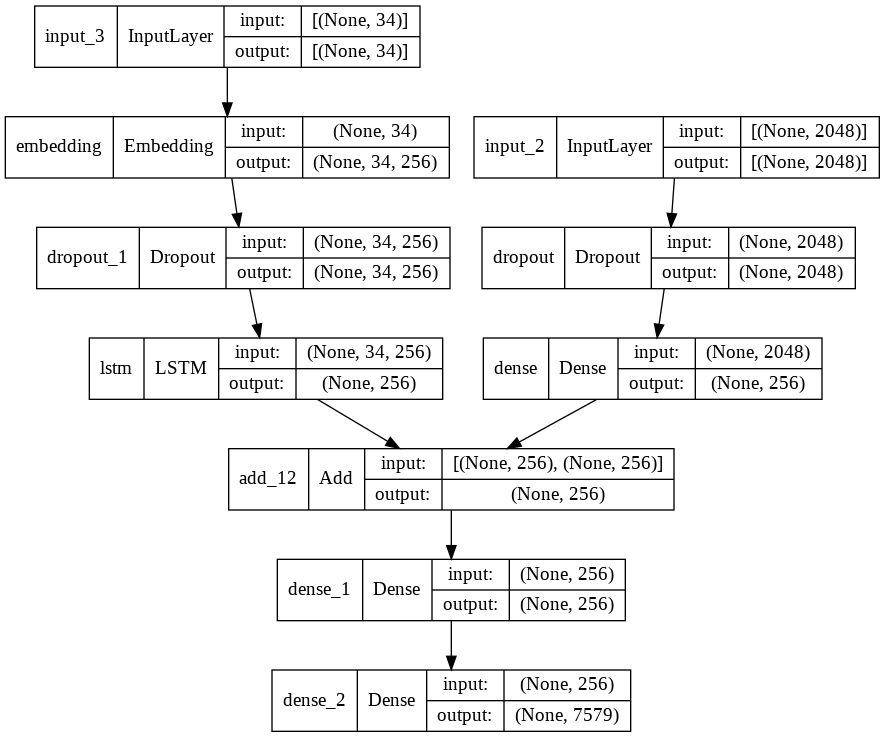

In [ ]:
plot_model(load_model(root_path+'Models/xception_model_best_dropout_0.h5'), to_file=root_path+'model.png', show_shapes=True)